In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
df = pd.read_csv('province_boundaries_nl.csv')

In [6]:
df

,FID,SHAPE,CBS_CODE,PROV_NAAM,OBJECTID
0,B1_Provinciegrenzen_van_Nederland.1,"POLYGON ((166000 609500, 163493.04 608559.89, ...",2,Friesland,1
1,B1_Provinciegrenzen_van_Nederland.2,"POLYGON ((101235.45 510060.27, 101223 509995, ...",7,Noord-Holland,2
2,B1_Provinciegrenzen_van_Nederland.3,"POLYGON ((170028.343 445109.103, 170046.564 44...",5,Gelderland,3
3,B1_Provinciegrenzen_van_Nederland.4,"POLYGON ((223906.541 555883.385, 223970.946 55...",3,Drenthe,4
4,B1_Provinciegrenzen_van_Nederland.5,"POLYGON ((121128.562 463852.646, 121134.863 46...",6,Utrecht,5
5,B1_Provinciegrenzen_van_Nederland.6,"POLYGON ((183893.796 341247.943, 183854.29 341...",11,Limburg,6
6,B1_Provinciegrenzen_van_Nederland.7,"POLYGON ((153237.54 520920.31, 153066.95 52102...",12,Flevoland,7
7,B1_Provinciegrenzen_van_Nederland.8,"POLYGON ((23205.42 400019.76, 21021.43 404838....",9,Zeeland,8
8,B1_Provinciegrenzen_van_Nederland.9,"MULTIPOLYGON (((142358.861 416946.4, 142260.86...",10,Noord-Brabant,9
9,B1_Provinciegrenzen_van_Nederland.10,"POLYGON ((72558 453255, 72500 453192.857, 7232...",8,Zuid-Holland,10


In [7]:
def parse_province(shape_data):
    shape_data = shape_data.split('(')[-1]
    shape_data = shape_data.split(')')[0]
    
    shape_list = shape_data.split(',')
    for i in range(len(shape_list)):
        if shape_list[i].startswith(' '):
            shape_list[i] = shape_list[i][1:]
            
    shape_list = [[x.split(' ')[0], x.split(' ')[1]] for x in shape_list]
    
    return np.asarray(shape_list, dtype=np.float)
    
parse_province(df['SHAPE'][0])

array([[166000.   , 609500.   ],
       [163493.04 , 608559.89 ],
       [162000.   , 608000.   ],
       ...,
       [175755.592, 609601.84 ],
       [170000.   , 612000.   ],
       [166000.   , 609500.   ]])

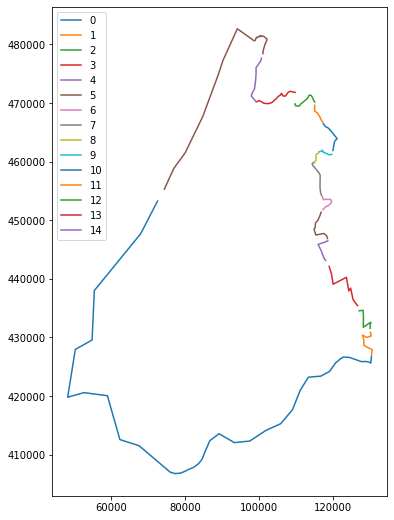

212


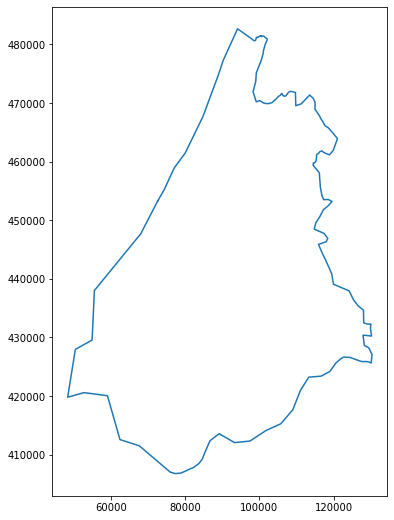

In [12]:
provincie = parse_province(df['SHAPE'][9])

step = 500
start = 0
end = 1 * step

plt.figure(figsize=(6, 9))
i = 0

lowpoly = []

while end <= len(provincie):
    
    if np.max([np.ptp(provincie[:,0][start:end]), np.ptp(provincie[:,1][start:end])]) <= 10000:
        plt.plot(provincie[:,0][start:end:50], 
                 provincie[:,1][start:end:50], label=i)
        
        for x in provincie[start:end:100]:
            lowpoly.append(x)
    else:
        plt.plot(provincie[:,0][start:end:10], 
                 provincie[:,1][start:end:10], label=i)
        
        for x in provincie[start:end:10]:
            lowpoly.append(x)
    
    start += step
    end += step
    i += 1
    
    #if i == 4:
    #    break

plt.legend()
plt.plot(provincie[:,0][start::10],
         provincie[:,1][start::10])
plt.show()

for x in provincie[start:end:10]:
    lowpoly.append(x)
    
#add first point to last to close 
lowpoly.append(lowpoly[0])

print(len(lowpoly))
lowpoly_ar= np.asarray(lowpoly)

plt.figure(figsize = (6,9))
plt.plot(lowpoly_ar[:,0], lowpoly_ar[:,1])
plt.show()

In [71]:
#normalise poly to 0-1, but keep dimensions
#find largest range
rng = np.max([np.ptp(lowpoly_ar[:,0]), np.ptp(lowpoly_ar[:,1])])
min_x = np.min(lowpoly_ar[:,0])
min_y = np.min(lowpoly_ar[:,1])

norm = (lowpoly_ar - np.array([min_x, min_y])) / rng

norm[:,0] = ((norm[:,0] - 0.2) / 1.75) + 0.31
norm[:,1] += 0.03

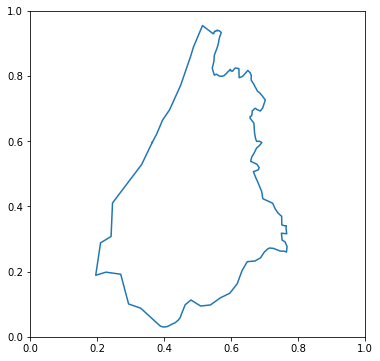

In [72]:
plt.figure(figsize=(6,6))
plt.plot(norm[:,0], norm[:,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [76]:
with open('noordholland.csv', 'w') as f:
    f.write('x,y\n')
    for x,y in norm:
        f.write('%f,%f\n' %(x, y))

In [9]:
def ray_tracing_numpy(x,y,poly):
    '''ray trace population relative to polygon
    
    Function that determines which population members are inside or
    outside the polygon (province) in a fast way analogous to ray tracing.
    
    Adapted from https://stackoverflow.com/a/57999874
    
    Keyword arguments
    -----------------
    x : int, float, ndarray
        x position(s) of population
        
    y : int, float, ndarray
        y position(s) of population
        
    poly : ndarray
        points describing the polygon. Lower point counts
        dramatically affect performance, especially on larger populations
    '''
    
    n = len(poly)
    inside = np.zeros(len(x),np.bool_)
    p2x = 0.0
    p2y = 0.0
    xints = 0.0
    p1x,p1y = poly[0]
    
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        idx = np.nonzero((y > min(p1y,p2y)) & (y <= max(p1y,p2y)) & (x <= max(p1x,p2x)))[0]
    
        if p1y != p2y:
            xints = (y[idx]-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
        
        if p1x == p2x:
            inside[idx] = ~inside[idx]
        
        else:
            idxx = idx[x[idx] <= xints]
            inside[idxx] = ~inside[idxx]    

        p1x,p1y = p2x,p2y
    return inside


pts = np.random.random(size=(10000,2))

In [18]:
from time import perf_counter

spd = np.zeros((100,))
pts = np.random.random(size=(10000,2))

for i in range(100):
    t1 = perf_counter()    
    #pts = pts[(pts[:,0] <= 0.1) & (pts[:,0] >= 0.9) &\
    #          (pts[:,1] <= 0.1) & (pts[:,1] >= 0.8)]
    ray_tracing_numpy(pts[:,0], pts[:,1], lowpoly_ar)
    spd[i] = perf_counter() - t1
    
print('average: %.4f, min: %.4f, max: %.4f' %(np.mean(spd), np.min(spd), np.max(spd)))

average: 0.0084, min: 0.0080, max: 0.0114


In [84]:
len(pts[ray_tracing_numpy(pts[:,0], pts[:,1], lowpoly_ar)])

0

499999999999.99945